In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xarray as xr
import pandas as pd
import cftime
import os
from glob import glob
from scipy.stats import linregress
from paulinggrl2022.twolyr import xregress, TwoLayerModel
from paulinggrl2022.cesm_functions import fixmonth, globalmean


mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
models = [
    "CESM2",
    "CNRM-CM6-1",
    "CanESM5",
    "GISS-E2-1-G",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MRI-ESM2-0"
]

experiments = ["piControl", "abrupt-0p5xCO2", "abrupt-4xCO2"]

variables = ["tas", "rsdt", "rsut", "rlut"]

droot = "../data/processed"

In [3]:
yrs = np.arange(1, 151)

ddict = {}
for name in models:
    print(name)
    ddict[name] = {}
    for exp in experiments:
        ddir = os.path.join(droot, name, exp)
        ddict[name][exp] = {}
        for var in variables:
            dfile = sorted(glob(os.path.join(ddir, var+"_"+name+"_"+exp+"_ens_tseries_r*_185001-199912.nc")))
            ds = xr.open_dataset(dfile[0])
            da = ds[var].groupby("time.year").mean('time')
            ddict[name][exp][var] = da.assign_coords({"year": ("year", yrs)})
            
            
        ddict[name][exp]["rtmt"] = ddict[name][exp]["rsdt"] - ddict[name][exp]["rsut"] - ddict[name][exp]["rlut"]

CESM2
CNRM-CM6-1
CanESM5
GISS-E2-1-G
IPSL-CM6A-LR
MIROC6
MRI-ESM2-0


In [4]:
anomdict = {}

for name in models:
    anomdict[name] = {}
    for exp in experiments[1:]:
        anomdict[name][exp] = {}
        for var in ["tas", "rtmt", "rsdt", "rsut"]:
            anomdict[name][exp][var] = ddict[name][exp][var] - ddict[name]["piControl"][var]

In [5]:
lamdict = {}
Fdict = {}
ecsdict = {}

for n, name in enumerate(models):
    lamdict[name] = {}
    Fdict[name] = {}
    ecsdict[name] = {}
    print(name)
    for exp in experiments[1:]:
        dT = anomdict[name][exp]["tas"]
        dR = anomdict[name][exp]["rtmt"]
        slope, intcpt = xregress(dT, dR)

        lamdict[name][exp] = slope.data[0]
        if exp == "abrupt-4xCO2":
            Fdict[name][exp] = intcpt.data[0]/2
            ecsdict[name][exp] = -intcpt.data[0]/slope.data[0]/2
        else:
            Fdict[name][exp] = -intcpt.data[0]
            ecsdict[name][exp] = intcpt.data[0]/slope.data[0]
        
        
        print(f"  {exp}: lambda = {slope.data[0]:5.3f}, F = {Fdict[name][exp]:5.3f}, ECS = {ecsdict[name][exp]:5.3f}")

CESM2
  abrupt-0p5xCO2: lambda = -0.841, F = 2.421, ECS = 2.878
  abrupt-4xCO2: lambda = -0.639, F = 3.274, ECS = 5.126
CNRM-CM6-1
  abrupt-0p5xCO2: lambda = -0.890, F = 3.054, ECS = 3.430
  abrupt-4xCO2: lambda = -0.749, F = 3.660, ECS = 4.883
CanESM5
  abrupt-0p5xCO2: lambda = -0.491, F = 2.709, ECS = 5.521
  abrupt-4xCO2: lambda = -0.648, F = 3.637, ECS = 5.614
GISS-E2-1-G
  abrupt-0p5xCO2: lambda = -1.652, F = 4.069, ECS = 2.463
  abrupt-4xCO2: lambda = -1.501, F = 4.033, ECS = 2.687
IPSL-CM6A-LR
  abrupt-0p5xCO2: lambda = -0.681, F = 2.779, ECS = 4.082
  abrupt-4xCO2: lambda = -0.748, F = 3.407, ECS = 4.556
MIROC6
  abrupt-0p5xCO2: lambda = -1.819, F = 2.945, ECS = 1.619
  abrupt-4xCO2: lambda = -1.443, F = 3.724, ECS = 2.581
MRI-ESM2-0
  abrupt-0p5xCO2: lambda = -1.113, F = 2.986, ECS = 2.682
  abrupt-4xCO2: lambda = -1.098, F = 3.442, ECS = 3.134


In [7]:
ddir = "../data/forcingdata"
ncsw_c = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.69.nonudge_novolc_icefix.cam.h0.FSNT.198501-200412.nc")
nclw_c = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.69.nonudge_novolc_icefix.cam.h0.FLNT.198501-200412.nc")

ncsw_v = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.70.nonudge_volc_icefix.cam.h0.FSNT.198501-200412.nc")
nclw_v = os.path.join(ddir, "f.e13.FSDW5.f19_f19.beta17_stratmam.70.nonudge_volc_icefix.cam.h0.FLNT.198501-200412.nc")

dssw_c = xr.open_dataset(ncsw_c)
dslw_c = xr.open_dataset(nclw_c)

dssw_v = xr.open_dataset(ncsw_v)
dslw_v = xr.open_dataset(nclw_v)

time = dssw_c.time.data
timetmp = [pd.to_datetime(t) for t in time]
timenew = [cftime.DatetimeNoLeap(t.year, t.month, t.day) for t in timetmp]

dssw_c = fixmonth(dssw_c.assign_coords({"time": ("time", timenew)}))
dslw_c = fixmonth(dslw_c.assign_coords({"time": ("time", timenew)}))

dssw_v = fixmonth(dssw_v.assign_coords({"time": ("time", timenew)}))
dslw_v = fixmonth(dslw_v.assign_coords({"time": ("time", timenew)}))

toa_c = dssw_c["FSNT"] - dslw_c["FLNT"]
toa_v = dssw_v["FSNT"] - dslw_v["FLNT"]

F_sw = globalmean(dssw_v["FSNT"] - dssw_c["FSNT"])
F_lw = -globalmean(dslw_v["FLNT"] - dslw_c["FLNT"])
F = F_sw + F_lw

In [8]:
T1_dict = {}
T2_dict = {}
T1_sum = {}
SW_dict = {}
SW_sum = {}
ratio = {}

params_dict = {}

timevec = pd.date_range("1985-01", "2004-12", freq="MS")
F_sw = F_sw.assign_coords({"time": ("time", timevec)})

for name in models:
    print(name)
    
    T1_dict[name] = {}
    T2_dict[name] = {}
    T1_sum[name] = {}
    SW_dict[name] = {}
    SW_sum[name] = {}
    ratio[name] = {}
    params_dict[name] = {}
    
    for exp in experiments[1:]:
        if exp == "abrupt-4xCO2":
            dT = anomdict[name][exp]["tas"]
            dN = anomdict[name][exp]["rtmt"]
            SW = anomdict[name][exp]["rsdt"] - anomdict[name][exp]["rsut"]
        else:
            dT = -anomdict[name][exp]["tas"]
            dN = -anomdict[name][exp]["rtmt"]
            SW = -(anomdict[name][exp]["rsdt"] - anomdict[name][exp]["rsut"])
            
        twolyr = TwoLayerModel()
        twolyr.fit_params(dT, dN)
        twolyr.fit_lambda_sw(dT, SW)
        
        T1, T2 = twolyr.solve_model(forcing=F, tstep=1/12)
        
        T1 = T1.interp(time=np.arange(240))
        T2 = T2.interp(time=np.arange(240))
        
        T1_dict[name][exp] = T1.assign_coords({"time": ("time", timevec)})
        T2_dict[name][exp] = T2.assign_coords({"time": ("time", timevec)})
        
        params_dict[name][exp] = twolyr.params
        
        SW_dict[name][exp] = F_sw - params_dict[name][exp]["lam_sw"]*T1_dict[name][exp]
    
        T1_sum[name][exp] = T1_dict[name][exp].sel(time=slice("1991-06", "1996-05")).sum("time")
        SW_sum[name][exp] = SW_dict[name][exp].sel(time=slice("1991-06", "1993-05")).sum("time")
        ratio[name][exp] = -T1_sum[name][exp]/SW_sum[name][exp]

CESM2
CNRM-CM6-1


/glade/u/home/apauling/miniconda3/envs/paulinggrl2022/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


CanESM5
GISS-E2-1-G


/glade/u/home/apauling/miniconda3/envs/paulinggrl2022/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/glade/u/home/apauling/miniconda3/envs/paulinggrl2022/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/glade/u/home/apauling/miniconda3/envs/paulinggrl2022/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


IPSL-CM6A-LR
MIROC6


/glade/u/home/apauling/miniconda3/envs/paulinggrl2022/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/glade/u/home/apauling/miniconda3/envs/paulinggrl2022/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


MRI-ESM2-0


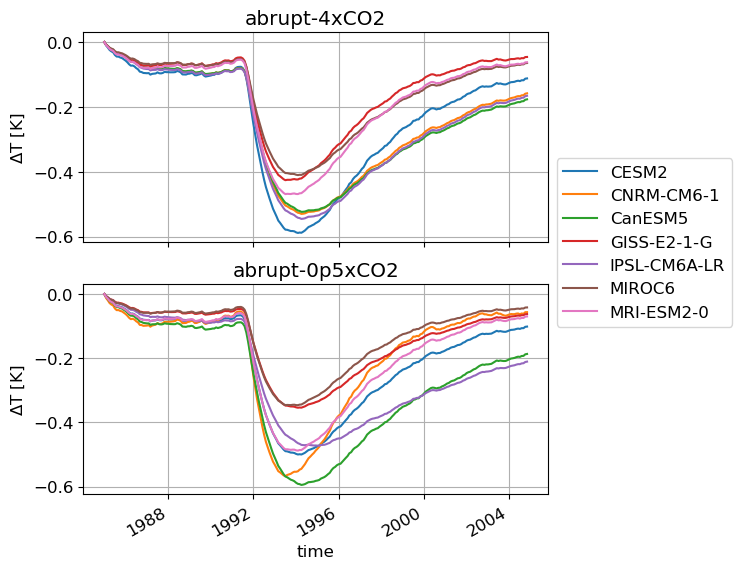

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

for name in models:
    T1_dict[name]["abrupt-4xCO2"].plot.line(
        x="time", 
        ax=ax1, 
        label=name, 
        add_legend=False
    )
    T1_dict[name]["abrupt-0p5xCO2"].plot.line(
        x="time", 
        ax=ax2, 
        label=name, 
        add_legend=False
    )
    
ax1.grid()
ax2.grid()

ax1.set_ylabel("$\Delta$T [K]")
ax2.set_ylabel("$\Delta$T [K]")

ax1.set_title("abrupt-4xCO2")
ax2.set_title("abrupt-0p5xCO2")
ax1.set_xlabel("")

ax1.legend(loc="center left", bbox_to_anchor=(1.0, 0))

In [10]:
import json

f = open('../data/ecsdata/cmip56_forcing_feedback_ecs.json','r')
data = json.load(f)

ecs_dict = {}

for name in models:
    ens = list(data["CMIP6"][name].keys())[0]
    test = data["CMIP6"][name][ens]["ECS"]
    print(f"{name} = {test}")
    ecs_dict[name] = test

CESM2 = 5.147915202979365
CNRM-CM6-1 = 4.9036506204610255
CanESM5 = 5.638903077035479
GISS-E2-1-G = 2.635084837796116
IPSL-CM6A-LR = 4.699160878253559
MIROC6 = 2.601790969650521
MRI-ESM2-0 = 3.1327957128560495


In [11]:
colors = pl.cm.tab20.colors

In [12]:
tarr = {}
swarr = {}
rarr = {}

slope_t_dict = {}
intcpt_t_dict = {}
r_t_dict = {}
p_t_dict = {}

slope_s_dict = {}
intcpt_s_dict = {}
r_s_dict = {}
p_s_dict = {}

slope_r_dict = {}
intcpt_r_dict = {}
r_r_dict = {}
p_r_dict = {}

ecsarr = np.array([ecs_dict[name] for name in models])

for exp in experiments[1:]:
    tarr[exp] = np.array([T1_sum[name][exp].data[0] for name in models])
    swarr[exp] = np.array([SW_sum[name][exp].data[0] for name in models])
    rarr[exp] = np.array([ratio[name][exp].data[0] for name in models])
    
    slope_t, intcpt_t, r_t, p_t, stderr_t = linregress(ecsarr, tarr[exp])
    slope_t_dict[exp] = slope_t
    intcpt_t_dict[exp] = intcpt_t
    r_t_dict[exp] = r_t
    p_t_dict[exp] = p_t
    
    slope_s, intcpt_s, r_s, p_s, stderr_s = linregress(ecsarr, swarr[exp])
    slope_s_dict[exp] = slope_s
    intcpt_s_dict[exp] = intcpt_s
    r_s_dict[exp] = r_s
    p_s_dict[exp] = p_s
    
    slope_r, intcpt_r, r_r, p_r, stderr_r = linregress(ecsarr, rarr[exp])
    slope_r_dict[exp] = slope_r
    intcpt_r_dict[exp] = intcpt_r
    r_r_dict[exp] = r_r
    p_r_dict[exp] = p_r

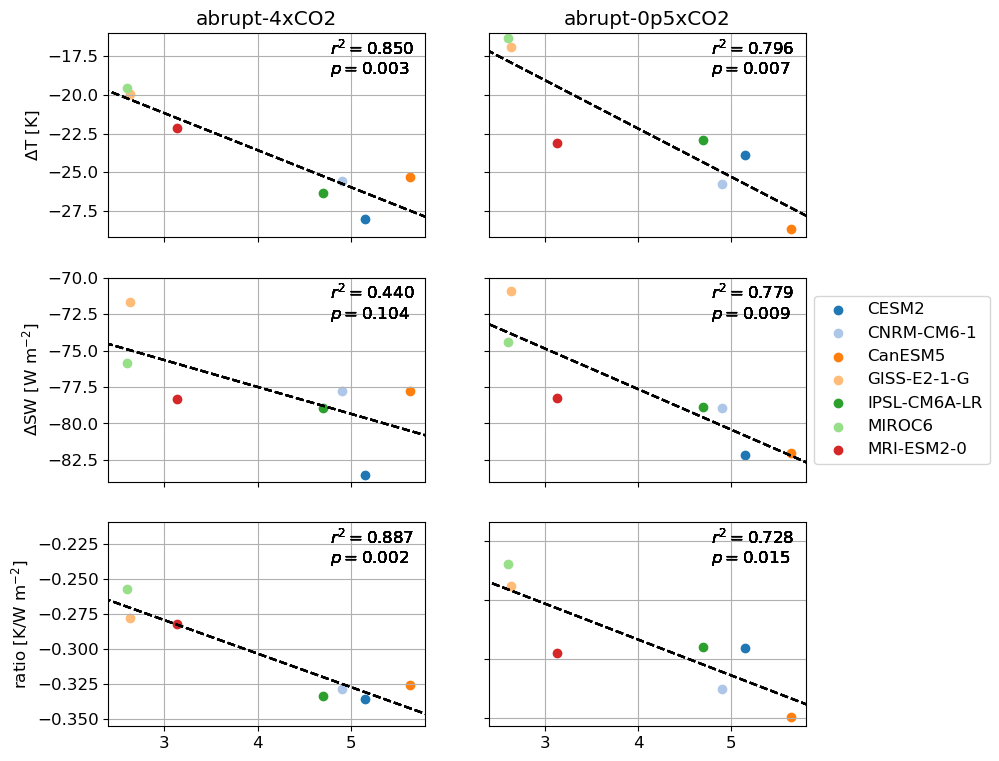

In [13]:
x = np.arange(1, 7)

fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(9, 9), sharex=True)
for n, name in enumerate(models):
    y = slope_t_dict["abrupt-4xCO2"]*x + intcpt_t_dict["abrupt-4xCO2"]
    ax1[0].scatter(ecs_dict[name], T1_sum[name]["abrupt-4xCO2"], color=colors[n])
    ax1[0].plot(x, y, "k--")
    ax1[0].grid()
    ax1[0].set_ylabel("$\Delta$T [K]")
    ax1[0].set_ylim(-29.2, -16)
    ax1[0].set_title("abrupt-4xCO2")
    ax1[0].set_xlim(2.4, 5.8)
    ax1[0].annotate(
        f"$r^2=${r_t_dict['abrupt-4xCO2']**2:5.3f}\n$p=${p_t_dict['abrupt-4xCO2']:5.3f}",
        xy=(0.7, 0.8),
        xycoords="axes fraction"
    )
    
    y = slope_t_dict["abrupt-0p5xCO2"]*x + intcpt_t_dict["abrupt-0p5xCO2"]
    ax1[1].scatter(ecs_dict[name], T1_sum[name]["abrupt-0p5xCO2"], color=colors[n])
    ax1[1].plot(x, y, "k--")
    ax1[1].grid()
    ax1[1].set_ylim(-29.2, -16)
    ax1[1].set_yticklabels("")
    ax1[1].set_title("abrupt-0p5xCO2")
    ax1[1].annotate(
        f"$r^2=${r_t_dict['abrupt-0p5xCO2']**2:5.3f}\n$p=${p_t_dict['abrupt-0p5xCO2']:5.3f}",
        xy=(0.7, 0.8),
        xycoords="axes fraction"
    )
    
    y = slope_s_dict["abrupt-4xCO2"]*x + intcpt_s_dict["abrupt-4xCO2"]
    ax2[0].scatter(ecs_dict[name], SW_sum[name]["abrupt-4xCO2"], color=colors[n])
    ax2[0].plot(x, y, "k--")
    ax2[0].grid()
    ax2[0].set_ylabel("$\Delta$SW [W m$^{-2}$]")
    ax2[0].set_ylim(-84, -70)
    ax2[0].annotate(
        f"$r^2=${r_s_dict['abrupt-4xCO2']**2:5.3f}\n$p=${p_s_dict['abrupt-4xCO2']:5.3f}",
        xy=(0.7, 0.8),
        xycoords="axes fraction"
    )
    
    y = slope_s_dict["abrupt-0p5xCO2"]*x + intcpt_s_dict["abrupt-0p5xCO2"]
    ax2[1].scatter(ecs_dict[name], SW_sum[name]["abrupt-0p5xCO2"], color=colors[n], label=name)
    ax2[1].plot(x, y, "k--")
    ax2[1].grid()
    ax2[1].set_ylim(-84, -70)
    ax2[1].set_yticklabels("")
    ax2[1].annotate(
        f"$r^2=${r_s_dict['abrupt-0p5xCO2']**2:5.3f}\n$p=${p_s_dict['abrupt-0p5xCO2']:5.3f}",
        xy=(0.7, 0.8),
        xycoords="axes fraction"
    )
    
    y = slope_r_dict["abrupt-4xCO2"]*x + intcpt_r_dict["abrupt-4xCO2"]
    ax3[0].scatter(ecs_dict[name], ratio[name]["abrupt-4xCO2"], color=colors[n])
    ax3[0].plot(x, y, "k--")
    ax3[0].grid()
    ax3[0].set_ylabel("ratio [K/W m$^{-2}$]")
    ax3[0].set_ylim(-0.355, -0.21)
    ax3[0].annotate(
        f"$r^2=${r_r_dict['abrupt-4xCO2']**2:5.3f}\n$p=${p_r_dict['abrupt-4xCO2']:5.3f}",
        xy=(0.7, 0.8),
        xycoords="axes fraction"
    )
    
    y = slope_r_dict["abrupt-0p5xCO2"]*x + intcpt_r_dict["abrupt-0p5xCO2"]
    ax3[1].scatter(ecs_dict[name], ratio[name]["abrupt-0p5xCO2"], color=colors[n])
    ax3[1].plot(x, y, "k--")
    ax3[1].grid()
    ax3[1].set_yticklabels("")
    ax3[1].annotate(
        f"$r^2=${r_r_dict['abrupt-0p5xCO2']**2:5.3f}\n$p=${p_r_dict['abrupt-0p5xCO2']:5.3f}",
        xy=(0.7, 0.8),
        xycoords="axes fraction"
    )

ax2[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

fig.savefig("../figures/twolyr_4x_vs_0p5x_fdbks_corr.png",
            bbox_inches="tight", dpi=300)

In [15]:
droot = "../data/processed"
histdict = {}

for name in models:
    print(name)
    histdict[name] = {}
    ddir = os.path.join(droot, name, "historical")
    
    for var in variables:
        if var == "tas":
            dfile = var+"_"+name+"_historical_ens_tseries_globmean_198001-201412.nc"
        else:
            dfile = var+"_"+name+"_historical_ens_tseries_tropmean_198001-201412.nc"
            
        ncf = os.path.join(ddir, dfile)
        
        ds = xr.open_dataset(ncf)
        
        histdict[name][var] = ds[var]
        
    histdict[name]["rsnt"] = histdict[name]["rsdt"] = histdict[name]["rsut"]

CESM2
CNRM-CM6-1
CanESM5
GISS-E2-1-G
IPSL-CM6A-LR
MIROC6
MRI-ESM2-0


In [16]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    dafit = da.where(np.logical_or(da.time < np.datetime64("1991-06"),
                                   da.time > np.datetime64("2001-05")),
                      drop=True)
    p = dafit.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [17]:
pert_dict = {}

for name in histdict.keys():

    tvar = "tas"
    rvar = "rsnt"
        
    pert_dict[name] = {}
    
    print(f"Model = {name}")
    
    temp = histdict[name][tvar]
    netsw = histdict[name][rvar]
                                       
    tanalysis = detrend_dim(temp.sel(time=slice("1986-01", "2005-12")), "time")
    tbase = tanalysis.sel(time=slice("1986-01", "1990-12"))
    
    sanalysis = detrend_dim(netsw.sel(time=slice("1986-01", "2005-12")), "time")
    sbase = sanalysis.sel(time=slice("1986-01", "1990-12"))
    
    tpert = tanalysis.groupby("time.month") - tbase.groupby("time.month").mean("time")
    spert = sanalysis.groupby("time.month") - sbase.groupby("time.month").mean("time")
    
    pert_dict[name]["tpert"] = tpert.compute()    
    pert_dict[name]["spert"] = spert.compute()

Model = CESM2
Model = CNRM-CM6-1
Model = CanESM5
Model = GISS-E2-1-G
Model = IPSL-CM6A-LR
Model = MIROC6
Model = MRI-ESM2-0


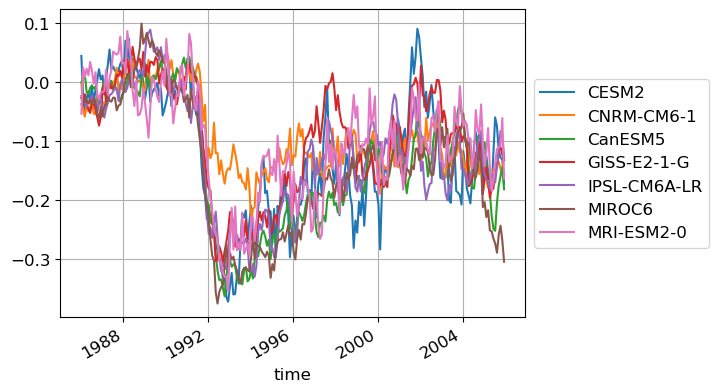

In [18]:
colors = pl.cm.tab10.colors
for n, name in enumerate(models):
    
    pert_dict[name]["tpert"].mean("ensmem").plot.line(
        x="time", 
        add_legend=False, 
        color=colors[n],
        label=name
    )
plt.grid()
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

CESM2
CNRM-CM6-1
CanESM5
GISS-E2-1-G
IPSL-CM6A-LR
MIROC6
MRI-ESM2-0


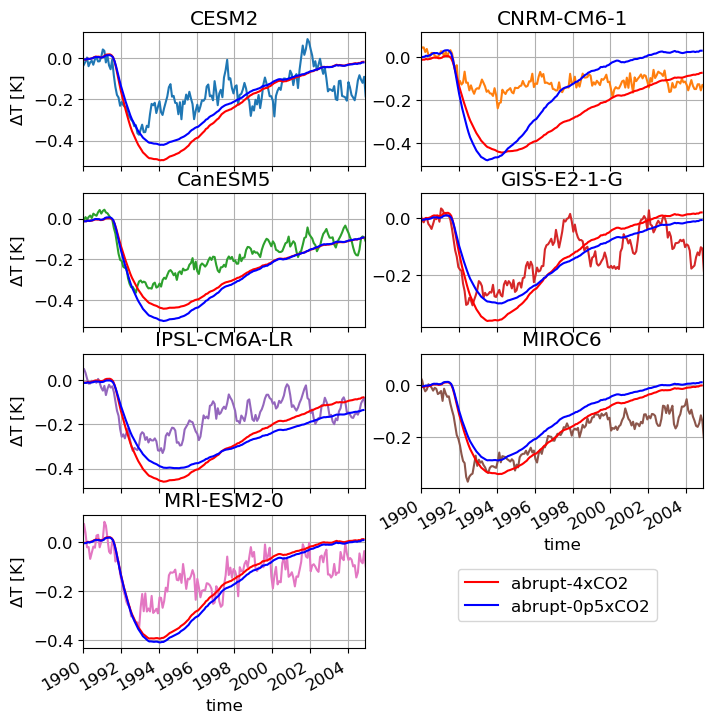

In [19]:
fig = plt.figure(1, figsize=(8, 8))

for n, name in enumerate(models):
    print(name)
    
    axs = fig.add_subplot(4, 2, n+1)
    pert_dict[name]["tpert"].mean("ensmem").plot.line(
        x="time",
        add_legend=False,
        color=colors[n]
    )
    
    da4 = T1_dict[name]["abrupt-4xCO2"]
    anom4 = da4 - da4.sel(time=slice("1986-01", "1990-12")).mean("time")
    anom4.plot.line(x="time", add_legend=False, color="red", label="abrupt-4xCO2")
    
    da5 = T1_dict[name]["abrupt-0p5xCO2"]
    anom5 = da5 - da5.sel(time=slice("1986-01", "1990-12")).mean("time")
    anom5.plot.line(x="time", add_legend=False, color="blue", label="abrupt-0p5xCO2")
    
    axs.grid()
    if n % 2 == 0:
        axs.set_ylabel("$\Delta$T [K]")
    else:
        axs.set_ylabel("")
    axs.set_title(name)
    if n < 5:
        axs.set_xlabel("")
        axs.set_xticklabels("")
        
    t1 = da4.time.sel(time="1990-01").data[0]
    t2 = da4.time.sel(time="2004-12").data[0]
    axs.set_xlim(t1, t2)
    
axs.legend(loc="center left", bbox_to_anchor=(1.3, 0.4))

fig.savefig("../figures/twolyr_dT_response_comparison.png",
            bbox_inches="tight", dpi=300)